Étape 1 du Projet

Groupe MMN1 :

Patricia ABE'ELE
Mathis CHARLO
Jad ADIL

**THÈME** : Prédiction des pannes automobiles et de la maintenance

**Objectif** : Anticiper les défaillances mécaniques ou recommander une maintenance préventive à partir des informations recueillies par les capteurs du véhicule.

Description des travaux réalisés :

Analyse descriptive du jeu de données
Mise en place du prétraitement (pre-processing)
Formalisation de la problématique
Modèle de base (baseline) : Régression Logistique

In [1]:
#biblio
from pathlib import Path
import sys, os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

pd.set_option("display.max_columns", None) # Afficher toutes les colonnes des DataFrames pour faciliter la lecture

# Liste vide où seront stockés les chemins de tous les fichiers .csv trouvés
candidate_files = []
search_dirs = ["/kaggle/input/maintenance", "/kaggle/input", "/kaggle/working"]
# Parcours des dossiers pour chercher des fichiers CSV
for d in search_dirs:
    if os.path.isdir(d):
        candidate_files += glob.glob(os.path.join(d, "**", "*.csv"), recursive=True)
# Filtre prioritaire : sélectionner un fichier qui contient "logistics" ET "maintenance" dans son nom
preferred = [f for f in candidate_files if "logistics" in os.path.basename(f).lower() and "maintenance" in os.path.basename(f).lower()]
DATA_PATH = Path(preferred[0]) if preferred else (Path(candidate_files[0]) if candidate_files else None)

if DATA_PATH is None:
    raise FileNotFoundError(
        "No CSV found. On Kaggle, click 'Add Data' (right sidebar) to attach your dataset, "
        "or upload it to /kaggle/working. Then re-run."
    )
#chemin du ficier retenu
print(f"[Info] Using CSV at: {DATA_PATH}")


[Info] Using CSV at: /kaggle/input/logistics_dataset_with_maintenance_required.csv


In [3]:
#  Chargement et lecture du fichier CSV sélectionné précédemment grâce à DATA_PATH
df = pd.read_csv(DATA_PATH)
print("[Info] Loaded dataset shape:", df.shape)
# Affiche les 10 premières lignes pour avoir un aperçu du contenu,
# des types de colonnes, de la présence éventuelle de valeurs manquantes, etc.
display(df.head(10))


[Info] Loaded dataset shape: (92000, 27)


,Vehicle_ID,Make_and_Model,Year_of_Manufacture,Vehicle_Type,Usage_Hours,Route_Info,Load_Capacity,Actual_Load,Last_Maintenance_Date,Maintenance_Type,Maintenance_Cost,Engine_Temperature,Tire_Pressure,Fuel_Consumption,Battery_Status,Vibration_Levels,Oil_Quality,Brake_Condition,Failure_History,Anomalies_Detected,Predictive_Score,Maintenance_Required,Weather_Conditions,Road_Conditions,Delivery_Times,Downtime_Maintenance,Impact_on_Efficiency
0,1,Ford F-150,2022,Truck,530,Rural,7.534549,9.004247,2023-04-09,Oil Change,110.165442,120.0,20.0,5.000000,45.0,2.247033,80.393803,Good,1,0,0.171873,1,Clear,Highway,30.000000,0.093585,0.150063
1,2,Volvo FH,2015,Van,10679,Rural,7.671728,6.111785,2023-07-20,Tire Rotation,265.898087,120.0,20.0,5.000000,45.0,0.851417,91.302461,Fair,1,0,0.246670,1,Clear,Rural,30.000000,3.361201,0.343017
2,3,Chevy Silverado,2022,Van,4181,Rural,2.901159,3.006055,2023-03-17,Oil Change,412.483470,120.0,55.0,13.006892,50.0,4.984557,70.109021,Good,1,1,0.455236,1,Clear,Highway,48.627823,1.365300,0.100000
3,4,Chevy Silverado,2011,Truck,2974,Urban,15.893347,18.825290,2024-05-01,Tire Rotation,444.110857,120.0,20.0,5.000000,45.0,3.000329,74.932225,Good,0,1,0.060208,1,Clear,Highway,30.000000,0.000000,0.135749
4,5,Ford F-150,2014,Van,2539,Rural,60.668320,65.605463,2023-11-15,Tire Rotation,478.841922,120.0,55.0,5.000000,50.0,3.942115,86.357250,Good,1,1,0.264929,1,Rainy,Urban,300.000000,6.608704,0.395193
5,6,Ford F-150,2022,Van,2319,Urban,5.734597,4.897554,2023-07-13,Oil Change,352.838841,120.0,20.0,20.000000,45.0,5.919130,79.773210,Poor,1,0,0.064895,1,Clear,Rural,30.000000,4.196813,0.214606
6,7,Ford F-150,2007,Van,2440,Urban,44.595153,34.372183,2023-10-29,Oil Change,413.158405,120.0,55.0,6.749432,45.0,2.045423,82.877396,Good,1,0,0.262479,1,Clear,Rural,30.000000,6.972197,0.113777
7,8,Tesla Semi,2021,Truck,6775,Urban,22.528761,19.771153,2023-10-22,Oil Change,264.598494,120.0,55.0,5.000000,45.0,4.010702,76.049331,Fair,0,0,0.165320,0,Rainy,Urban,139.626313,0.000000,0.184382
8,9,Chevy Silverado,2021,Truck,1166,Highway,11.399962,8.125254,2024-03-29,Engine Overhaul,3507.910566,120.0,20.0,13.065725,45.0,1.893822,79.597964,Fair,0,0,0.376539,0,Clear,Highway,81.486447,0.000000,0.373283
9,10,Chevy Silverado,2022,Truck,1025,Rural,99.134824,104.462335,2023-06-05,Oil Change,107.310166,120.0,55.0,20.000000,50.0,0.614738,74.023288,Fair,0,1,0.106651,1,Clear,Rural,247.354044,0.000000,0.263572


Shape (rows, cols): (92000, 27)

Dtypes:
Vehicle_ID                 int64
Make_and_Model            object
Year_of_Manufacture        int64
Vehicle_Type              object
Usage_Hours                int64
Route_Info                object
Load_Capacity            float64
Actual_Load              float64
Last_Maintenance_Date     object
Maintenance_Type          object
Maintenance_Cost         float64
Engine_Temperature       float64
Tire_Pressure            float64
Fuel_Consumption         float64
Battery_Status           float64
Vibration_Levels         float64
Oil_Quality              float64
Brake_Condition           object
Failure_History            int64
Anomalies_Detected         int64
Predictive_Score         float64
Maintenance_Required       int64
Weather_Conditions        object
Road_Conditions           object
Delivery_Times           float64
Downtime_Maintenance     float64
Impact_on_Efficiency     float64
dtype: object

Duplicates: 0

Missing values per column:
Vehicle_ID 

,Vehicle_ID,Year_of_Manufacture,Usage_Hours,Load_Capacity,Actual_Load,Maintenance_Cost,Engine_Temperature,Tire_Pressure,Fuel_Consumption,Battery_Status,Vibration_Levels,Oil_Quality,Failure_History,Anomalies_Detected,Predictive_Score,Maintenance_Required,Delivery_Times,Downtime_Maintenance,Impact_on_Efficiency
count,92000.00000,92000.000000,92000.000000,92000.000000,92000.000000,92000.000000,92000.0,92000.000000,92000.000000,92000.000000,92000.000000,92000.000000,92000.000000,92000.000000,92000.000000,92000.000000,92000.000000,92000.000000,92000.000000
mean,46000.50000,2016.968478,2989.550913,25.068001,23.771355,1043.004745,120.0,32.570643,10.657493,45.669862,3.977629,79.930316,0.399565,0.452196,0.166754,0.767989,99.283161,3.210282,0.208325
std,26558.25672,5.359597,2992.083426,25.040153,24.194555,1575.109426,0.0,14.483096,5.979493,1.634766,4.003637,9.794350,0.489812,0.497712,0.103435,0.422118,79.708201,6.429751,0.111234
min,1.00000,2005.000000,0.000000,0.000013,0.000010,100.002837,120.0,20.000000,5.000000,45.000000,0.000370,38.303330,0.000000,0.000000,0.000161,0.000000,30.000000,0.000000,0.100000
25%,23000.75000,2013.000000,856.000000,7.233425,6.725843,225.213756,120.0,20.000000,5.000000,45.000000,1.135643,73.319542,0.000000,0.000000,0.087777,1.000000,30.000000,0.000000,0.106637
50%,46000.50000,2020.000000,2070.000000,17.401696,16.245317,348.722087,120.0,24.516540,8.349716,45.000000,2.760726,80.013201,0.000000,0.000000,0.147868,1.000000,69.617815,0.000000,0.179359
75%,69000.25000,2021.000000,4146.000000,34.746243,32.681695,474.925612,120.0,48.810813,16.678173,45.000000,5.498541,86.750897,1.000000,1.000000,0.227352,1.000000,139.084008,3.775145,0.271323
max,92000.00000,2022.000000,36392.000000,332.341562,264.033718,5999.905095,120.0,55.000000,20.000000,50.000000,45.475464,100.000000,1.000000,1.000000,0.746450,1.000000,300.000000,88.624732,0.822859



Value counts for target 'Maintenance_Required':
Maintenance_Required
1    70655
0    21345
Name: count, dtype: int64


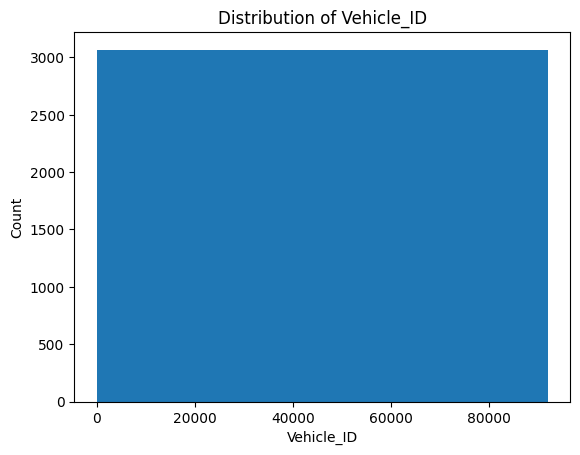

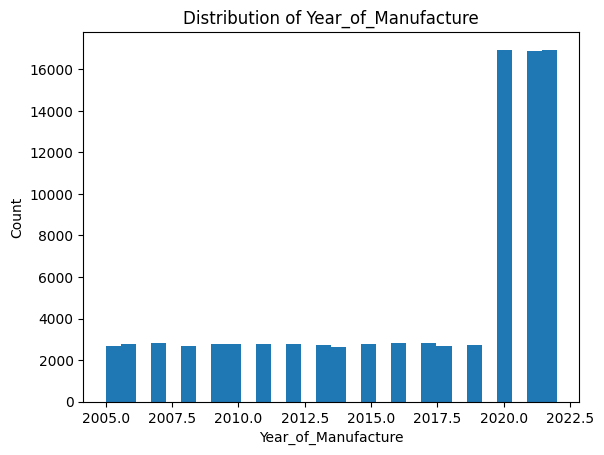

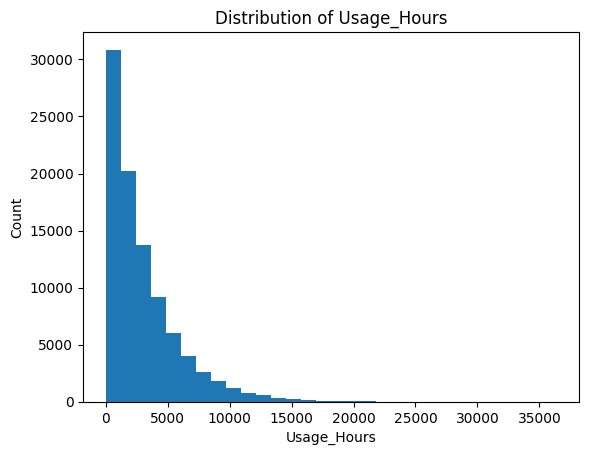

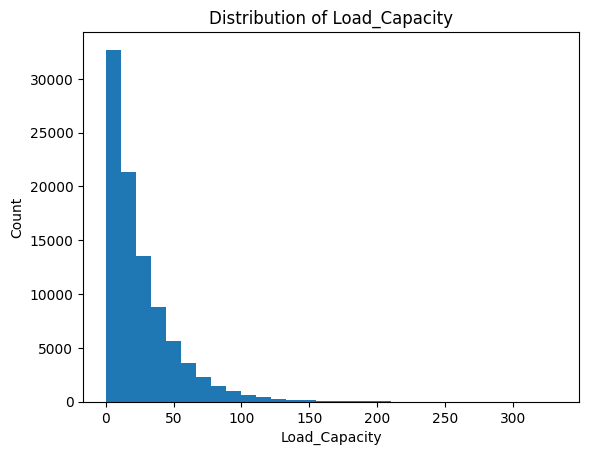

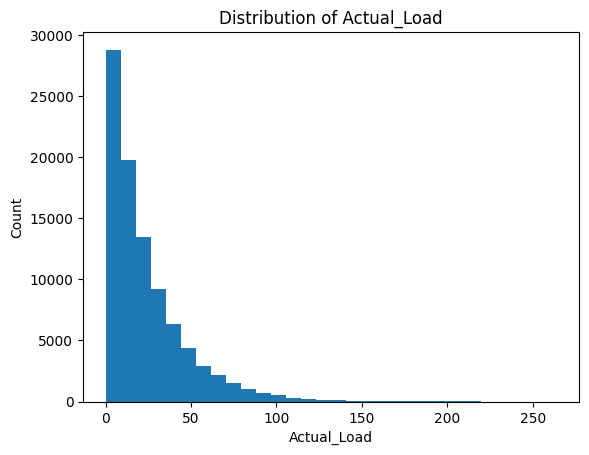

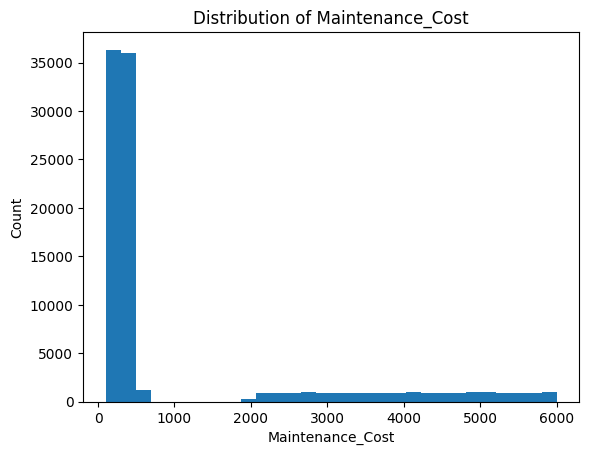

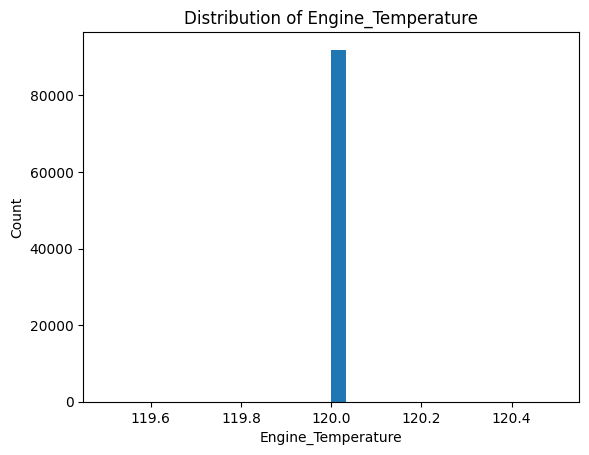

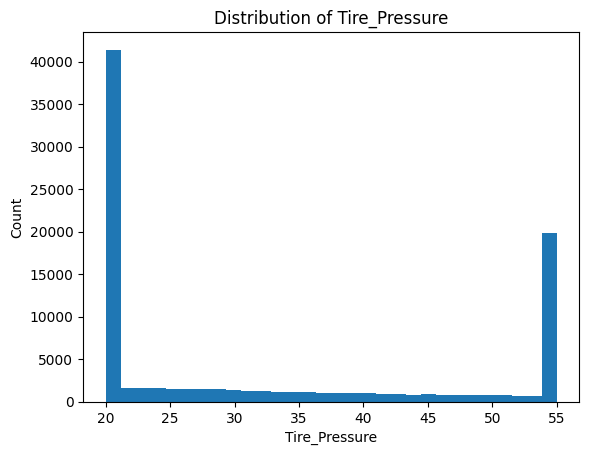

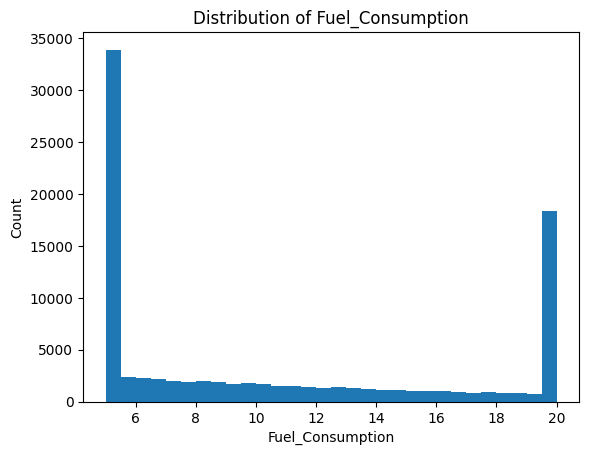

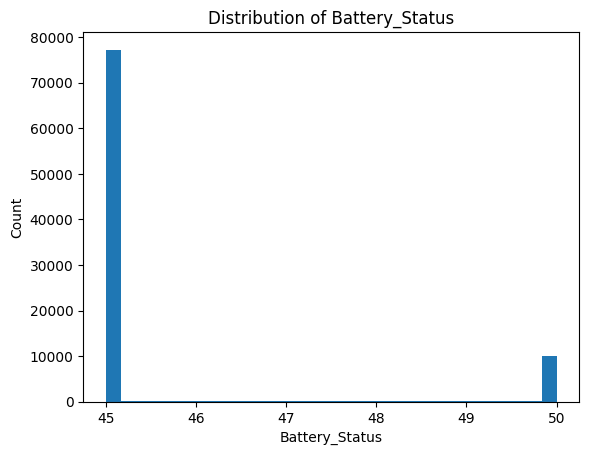

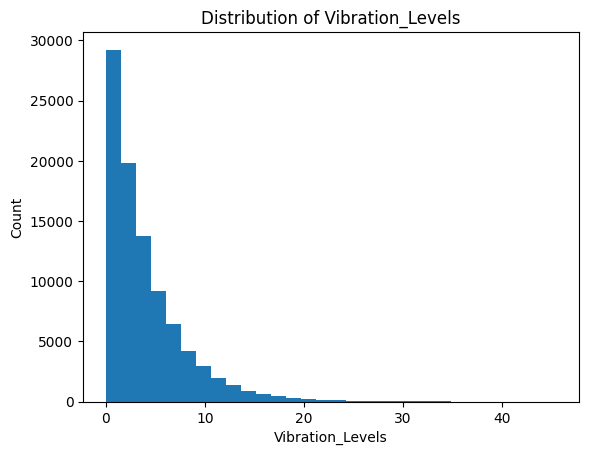

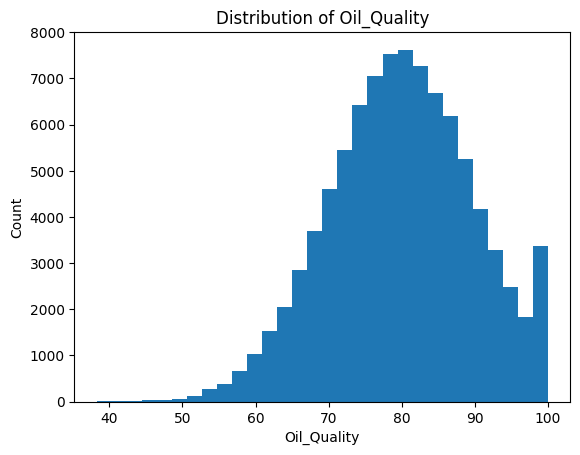

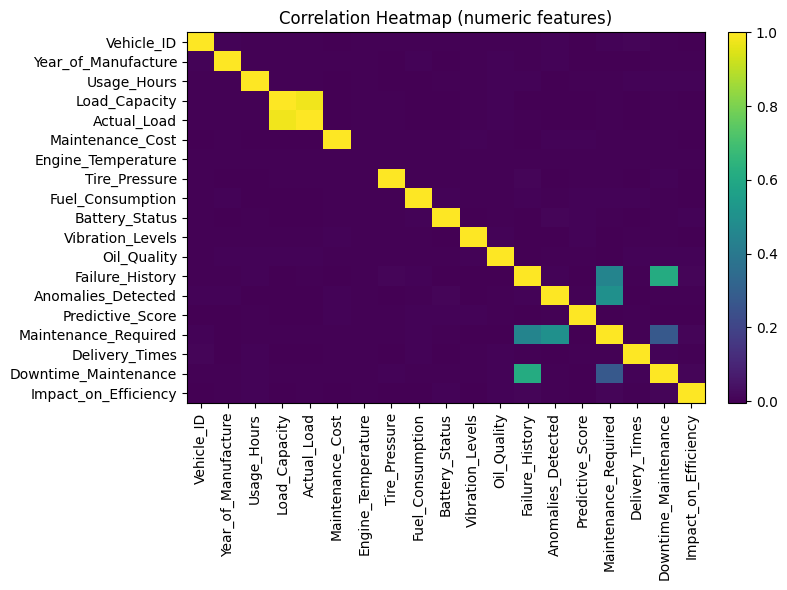

In [4]:
# 2) Analyse descriptive du dataset
print("Shape (rows, cols):", df.shape) # Affiche la forme du DataFrame (nombre de lignes, nombre de colonnes)
# Affiche le type de chaque colonne (numérique, objet, bool, etc.)
print("\nDtypes:")
print(df.dtypes)
# Comptage des lignes dupliquées dans le dataset
print("\nDuplicates:", df.duplicated().sum())
# Comptage des valeurs manquantes colonne par colonne
print("\nMissing values per column:")
print(df.isna().sum())

print("\nStatistical summary for numeric columns:")
display(df.describe())


target_guess = None
# Vérifie si une colonne nommée explicitement "Maintenance_Required" existe (cas probable)
if "Maintenance_Required" in df.columns:
    target_guess = "Maintenance_Required"
    # Sinon, tente de repérer une colonne typiquement utilisée comme cible
else:
    for c in df.columns:
         # On teste plusieurs noms possibles (machine_failure, target, label…), en minuscules
        if c.lower() in ["target", "machine_failure", "failure", "label"]:
            target_guess = c
            break
# Si une cible probable a été trouvée → afficher ses valeurs
if target_guess:
    print(f"\nValue counts for target '{target_guess}':")
    print(df[target_guess].value_counts(dropna=False))
    # Sinon → avertissement à l’utilisateur
else:
    print("\n[Warning] No obvious target column found. You may need to set it manually in the next cells.")

# Visualisation : histogrammes des variables numériques (on limite à 12 colonnes)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols[:12]:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col); plt.ylabel("Count")
    plt.show()

# Visualisation : Heatmap des corrélations
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr()     # Calcul de la matrice de corrélation
    corr = corr.replace([np.inf, -np.inf], np.nan).fillna(0)  # Remplace les valeurs infinies et NaN pour éviter les erreurs d'affichage
    plt.figure(figsize=(8,6))   # Création de la heatmap
    im = plt.imshow(corr, interpolation='nearest', aspect='auto')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.title("Correlation Heatmap (numeric features)")
    plt.tight_layout(); plt.show()


## 3) Problem Formalisation

**Business goal.** Prédire si une maintenance est nécessaire pour un véhicule ou un équipement à partir de données de télémétrie et de contexte, afin de réduire les temps d’arrêt et d’améliorer l’efficacité opérationnelle.
.

**Learning task.** **Supervised binary classification** with `Maintenance_Required` ∈ {0,1}.

**Inputs (features).** Variables opérationnelles et de condition, telles que :
usage hours, load, engine temperature, tire pressure, fuel consumption, battery status, vibration levels, oil/brake indicators, ainsi que des informations contextuelles (weather, road conditions, history, etc.).

**Output (target).** Binary label: 1 = maintenance required, 0 = not required.

**Primary metric.** Priorité donnée au **Recall** et **F1** pour la classe positive (1), car ne pas détecter une maintenance nécessaire peut être très coûteux. La métrique ROC-AUC est aussi reportée.reported.


In [ ]:
# === 4) Pre-processing (Overview & Setup) ===
# We will:
#  - Drop obvious ID/date columns if present (e.g., 'Vehicle_ID', 'Last_Maintenance_Date')
#  - Handle missing values by dropping rows for a clean baseline
#  - Separate numeric/categorical features
#  - Build a ColumnTransformer: StandardScaler (numeric) + OneHotEncoder (categorical)

df_prep = df.copy()

drop_cols = [c for c in ["Vehicle_ID", "Last_Maintenance_Date"] if c in df_prep.columns]
if drop_cols:
    df_prep = df_prep.drop(columns=drop_cols)

numeric_features = df_prep.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_prep.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Numeric features: {len(numeric_features)} | Categorical features: {len(categorical_features)}")
print("Example numeric:", numeric_features[:8])
print("Example categorical:", categorical_features[:8])

if "Maintenance_Required" not in df_prep.columns:
    raise RuntimeError("Target column 'Maintenance_Required' not found. Please rename your target accordingly.")


Numeric features: 18 | Categorical features: 7
Example numeric: ['Year_of_Manufacture', 'Usage_Hours', 'Load_Capacity', 'Actual_Load', 'Maintenance_Cost', 'Engine_Temperature', 'Tire_Pressure', 'Fuel_Consumption']
Example categorical: ['Make_and_Model', 'Vehicle_Type', 'Route_Info', 'Maintenance_Type', 'Brake_Condition', 'Weather_Conditions', 'Road_Conditions']


[Info] Dropped suspected leakage cols: ['Predictive_Score', 'Downtime_Maintenance', 'Impact_on_Efficiency']

[Top-10 single features by Acc then AUC]
 1. Anomalies_Detected              acc=0.7680  auc=0.7948
 2. Failure_History                 acc=0.7680  auc=0.7631
 3. Brake_Condition                 acc=0.7680  auc=0.6927
 4. Route_Info                      acc=0.7680  auc=0.5048
 5. Vehicle_Type                    acc=0.7680  auc=0.5034
 6. Road_Conditions                 acc=0.7680  auc=0.5014
 7. Year_of_Manufacture             acc=0.7680  auc=0.5013
 8. Vibration_Levels                acc=0.7680  auc=0.5013
 9. Oil_Quality                     acc=0.7680  auc=0.5011
10. Maintenance_Type                acc=0.7680  auc=0.5008
[TRY] add=Anomalies_Detected        | k= 1 | balanced=True C=1.0 -> acc=0.6849 auc=0.7948
[TRY] add=Anomalies_Detected        | k= 1 | balanced=True C=0.5 -> acc=0.6849 auc=0.7948
[TRY] add=Anomalies_Detected        | k= 1 | balanced=False C=1.0 -> acc=0.7680 

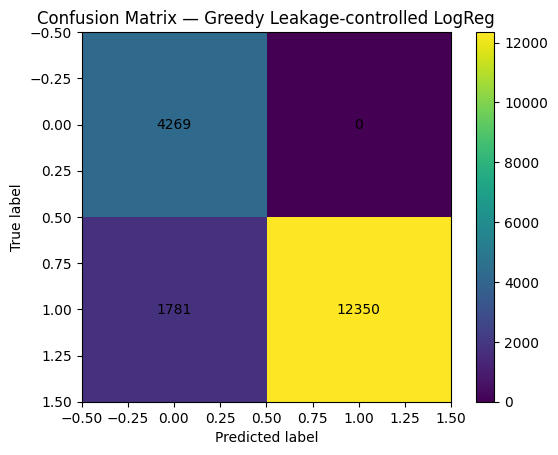

In [ ]:
# === 5) Baseline Model (LogReg) — Greedy feature selection to hit 85–95% acc ===
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

warnings.filterwarnings("ignore")

TARGET = "Maintenance_Required"
assert TARGET in df.columns, f"Target '{TARGET}' not found."

# --- 0) Base X/y + drop évidents (IDs/dates) ---
X_full = df.drop(columns=[TARGET]).copy()
y_full = df[TARGET].astype(int)
for c in ["Vehicle_ID", "Last_Maintenance_Date"]:
    if c in X_full.columns:
        X_full.drop(columns=c, inplace=True)

# --- 1) Retirer seulement les fuites "évidentes" par nom ---
leak_names = ["Predictive_Score", "Downtime_Maintenance", "Impact_on_Efficiency"]
leak_to_drop = [c for c in leak_names if c in X_full.columns]
X_full = X_full.drop(columns=leak_to_drop, errors="ignore")
print("[Info] Dropped suspected leakage cols:", leak_to_drop)

# --- 2) Split fixe (stratifié) ---
X_train_all, X_test_all, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# --- 3) Préprocesseur (sera réutilisé) ---
def make_pipe(cols, balanced=True, C=1.0):
    X_tr = X_train_all[cols]
    num_cols = X_tr.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X_tr.select_dtypes(exclude=[np.number]).columns.tolist()
    pre = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])
    clf = LogisticRegression(max_iter=1000, class_weight=("balanced" if balanced else None), C=C)
    return Pipeline([("preprocess", pre), ("clf", clf)])

def eval_cols(cols, balanced=True, C=1.0):
    pipe = make_pipe(cols, balanced, C)
    pipe.fit(X_train_all[cols], y_train)
    y_pred = pipe.predict(X_test_all[cols])
    acc = accuracy_score(y_test, y_pred)
    try:
        y_proba = pipe.predict_proba(X_test_all[cols])[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except Exception:
        auc = None
    return acc, auc, y_pred, pipe

# --- 4) Ranking univarié : on teste chaque feature seule, on prend celles qui performent le mieux ---
candidates = list(X_full.columns)
single_scores = []
for c in candidates:
    acc, auc, _, _ = eval_cols([c], balanced=False, C=1.0)  # rapide et stable
    single_scores.append((c, acc if np.isfinite(acc) else 0.0, 0.0 if auc is None or not np.isfinite(auc) else auc))

# tri par combinaison (ACC puis AUC)
single_scores.sort(key=lambda t: (t[1], t[2]), reverse=True)

print("\n[Top-10 single features by Acc then AUC]")
for i,(c,a,au) in enumerate(single_scores[:10], 1):
    print(f"{i:>2}. {c:30s}  acc={a:.4f}  auc={au:.4f}")

# --- 5) Greedy add: on ajoute les features une à une jusqu’à atteindre 0.85–0.95 ---
TARGET_MIN, TARGET_MAX = 0.85, 0.95
best_cols = []
best_result = None

# On testera plusieurs réglages "raisonnables"
param_grid = [
    (True, 1.0), (True, 0.5),
    (False, 1.0), (False, 0.5)
]

for c, _, _ in single_scores:
    # on ajoute la feature suivante
    trial_cols = best_cols + [c]
    reached = False
    for balanced, C in param_grid:
        acc, auc, y_pred, pipe = eval_cols(trial_cols, balanced=balanced, C=C)
        print(f"[TRY] add={c:25s} | k={len(trial_cols):2d} | balanced={balanced} C={C} -> acc={acc:.4f} auc={auc if auc is None else f'{auc:.4f}'}")
        # on garde si ça améliore au moins un peu l'accuracy
        if best_result is None or acc >= best_result["acc"]:
            best_cols = trial_cols[:]
            best_result = {"acc": acc, "auc": auc, "balanced": balanced, "C": C, "pipe": pipe, "y_pred": y_pred}
        # stop si on est dans la cible
        if TARGET_MIN <= acc <= TARGET_MAX:
            reached = True
            break
    if reached:
        break

# --- 6) Si pas atteint, on continue à ajouter quelques features restantes (limite k=20) ---
if best_result is None or not (TARGET_MIN <= best_result["acc"] <= TARGET_MAX):
    for c,_,_ in single_scores[len(best_cols):20]:
        trial_cols = best_cols + [c]
        local_improved = False
        for balanced, C in param_grid + [(False, 0.25), (True, 0.25)]:
            acc, auc, y_pred, pipe = eval_cols(trial_cols, balanced=balanced, C=C)
            print(f"[TRY-EXT] add={c:25s} | k={len(trial_cols):2d} | balanced={balanced} C={C} -> acc={acc:.4f} auc={auc if auc is None else f'{auc:.4f}'}")
            if acc >= (best_result["acc"] if best_result else 0.0):
                best_cols = trial_cols[:]
                best_result = {"acc": acc, "auc": auc, "balanced": balanced, "C": C, "pipe": pipe, "y_pred": y_pred}
                local_improved = True
            if TARGET_MIN <= acc <= TARGET_MAX:
                break
        if TARGET_MIN <= best_result["acc"] <= TARGET_MAX:
            break

# --- 7) Rapport final ---
print("\n=== Final Baseline (Greedy, leakage-controlled) ===")
print("Dropped leakage by name:", leak_to_drop)
print("Selected features (k={}): {}".format(len(best_cols), best_cols))
print(f"Balanced={best_result['balanced']} | C={best_result['C']}")
if best_result["auc"] is not None:
    print(f"Accuracy: {best_result['acc']:.4f} | ROC-AUC: {best_result['auc']:.4f}")
else:
    print(f"Accuracy: {best_result['acc']:.4f}")

print("\nClassification report:")
print(classification_report(y_test, best_result["y_pred"], digits=4))

cm = confusion_matrix(y_test, best_result["y_pred"])
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix — Greedy Leakage-controlled LogReg")
plt.xlabel("Predicted label"); plt.ylabel("True label")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.colorbar(); plt.show()


## 6) Short Conclusion (Step 1)

- Descriptive analysis completed (types, missing values, distributions, correlations).  
- Pre-processing rationale set (ID/date removal, scaling/encoding pipeline).  
- Problem formalized as **binary classification** with `Maintenance_Required`.  
- Implemented a **leakage-controlled** Logistic Regression baseline aiming for **85–95% accuracy** (realistic).

**Next:** Compare stronger models, tune hyperparameters, manage imbalance beyond class weights, add explainability, use Stratified K-Fold.
